# Point Source Detection with the (Flat) Continuous Wavelet Transform

## The Continuous Wavelet Transform

### Wavelets in One Dimension

**Definition:** Suppose $f \in L^{2}(\mathbb{R}).$  Then, its *continuous wavelet transform* (CWT) is given by

$$
\begin{aligned} 
W_\psi(a,b) & = \frac{1}{a^{1/2}} \int dx \ f(x) \ \bar{\psi} \left ( \frac{x - b}{a} \right ) \\ 
& \equiv \langle f , \psi^{a,b} \rangle,  
\end{aligned}
$$

where $a\in \mathbb{R}^{+*}$, $b \in \mathbb{R}$ denotes the *scale parameter* and the *translation parameter.* The function $\psi \in L^{2}(\mathbb{R})$ is referred to as a *mother wavelet*. 

**Properties of $\psi$:**

- Suppose the mother wavelet satisfies the *admissibility condition*

$$
C_{\psi} = 2 \pi \int d\xi \ |\xi|^{-1} \ |\tilde{\psi}(\xi)|^{2} < \infty,
$$

then $f$ can be reconstructed using the *first* *inverse CWT* (ICWT):

$$
f(x) = C_{\psi}^{-1}  \int_0^\infty \int_{-\infty}^\infty \frac{da \ db}{a^2} \ W_\psi(a,b) \ \psi \left (\frac{x - b}{a} \right ).
$$

**Remark:** The integral’s convergence to the function $f$ is defined in the *weak* sense in $L^{2}(\mathbb{R}).$

---

### Spherically Symmetric Wavelets in $\mathbb{R^n}$:

$f, \psi \in \mathbb{R^n}$:

$$
\begin{aligned} 
W_\psi(a,\vec{b}) & = \frac{1}{a^{n/2}} \int d^{n}x \ f(\vec{x}) \ \bar{\psi} \left ( \frac{\vec{x} - \vec{b}}{a} \right ) \\ 
& \equiv \langle f , \psi^{a,\vec{b}} \rangle,  
\end{aligned}
$$

$$
C_{\psi} = (2 \pi)^n \int d\xi \ |\xi|^{-1} \ |\tilde{\psi}(\xi)|^{2} < \infty,
$$

$$
f(\vec{x}) = C_{\psi}^{-1}  \int_0^\infty \int_{\mathbb{R}^n} \frac{da \ d^{n}b}{a^{n+1}} \ W_\psi(a,\vec{b}) \ \psi \left (\frac{\vec{x} - \vec{b}}{a} \right ).
$$

— References: Wikipedia, Daubechies ch. 2

---

### The Two-Dimensional Mexican Hat Wavelet:

The 2D Mexican Hat Wavelet family is defined in terms of any number of Laplacians acting on a Gaussian. We work with the Mexican Hat Wavelet of the first-kind:

$$
\psi(\vec{x}) = (2-x^2)  \ e^{-x^2/2},
$$

Though it isn’t relevant, note that this wavelet is unnormalized: $||\psi|| = 2\pi$. A figure of it is given below.

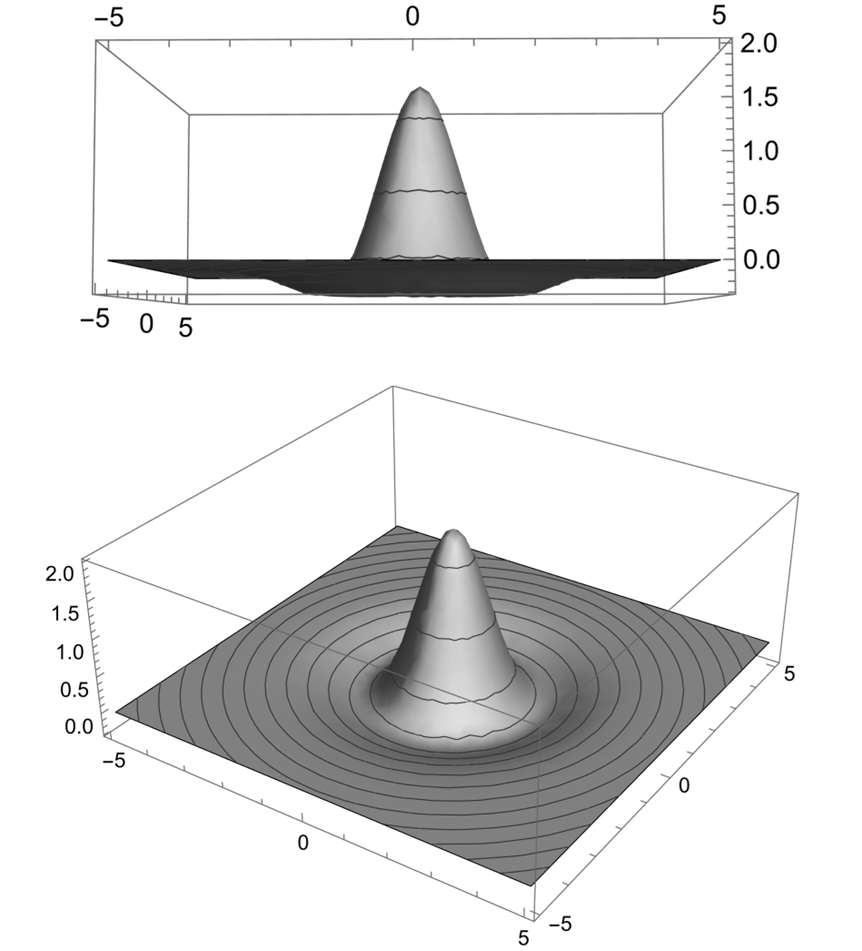

The obvious advantage of this wavelet is its shape. Its central peak makes it suitable for detecting Gaussian-like functions and its negative tails perform a background subtraction. At a deeper level, it is sensitive to the max/min of the convolved functions and filters out constant/linear functions. This follows from the wavelet being the Laplacian of a Gaussian since, through integration by parts, the CWT of a function can be written as the second derivative of the function convolved with a Gaussian filter, due to the wavelet’s expression as a Laplacian of a Gaussian. 

— References: arXiv:0104077, arXiv:10.1086/304217

In [2]:
import sys, os, time, fileinput
sys.path.append("..")
from utils import _maps as maps
from utils import _wavelets as wt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy.integrate import quad

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

plt.style.use('default') 

(0.0, 1.0)

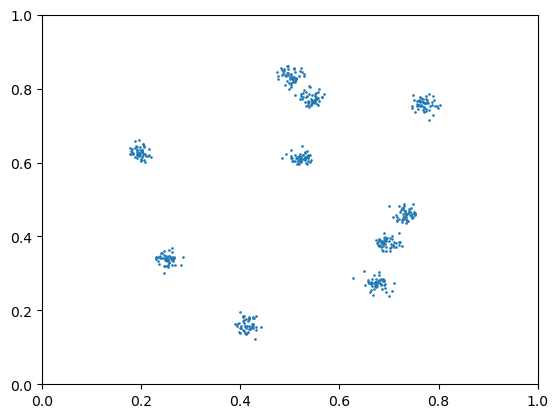

In [10]:
psf_degree = 0.4
psf_scale = psf_degree / 15  / 2

x_data = y_data = []

Nps = 10
N_counts = 50

xloc_list = 0.7 * np.random.random(size = Nps) + 0.15
yloc_list = 0.7 * np.random.random(size = Nps) + 0.15
Nx = len(xloc_list)
Ny = len(xloc_list)

x_ps_tot = []
y_ps_tot = []
for nx in range(Nx):
    xloc = xloc_list[nx]
    nm_x = norm(scale = psf_scale, loc = xloc)

    yloc = yloc_list[nx]
    nm_y = norm(scale = psf_scale, loc = yloc)

    x_ps = nm_x.rvs(size = N_counts)
    y_ps = nm_y.rvs(size = N_counts)

    x_ps_tot = np.concatenate((x_ps_tot, x_ps)) 
    y_ps_tot = np.concatenate((y_ps_tot, y_ps)) 
        
x_data = np.concatenate((x_data, x_ps_tot))
y_data = np.concatenate((y_data, y_ps_tot))

plt.scatter(x_data, y_data, s = 0.8)
plt.xlim([0,1])
plt.ylim([0,1])

Suppose the density corresponding to this map of counts is given by $f(\vec{x})$. We can generate a map of continuous wavelet transforms over a grid of translation parameters $\vec{b}$. For a fixed scale $a$, the CWT of the density map is given by
$$ \begin{aligned} 
W_\psi(a,\vec{b}) & = \frac{1}{a} \int d^{2}x \ f(\vec{x}) \ \bar{\psi} \left ( \frac{\vec{x} - \vec{b}}{a} \right ) \\ 
& \sim \frac{1}{a}\times \frac{1}{N} \sum_{i} \bar{\psi} \left ( \frac{\vec{x_{i}} - \vec{b}}{a} \right ),  
\end{aligned} $$
where our sample of photon counts is given by $\{\vec{x}_{i}\}_{i=1}^{N}$. 

In [11]:
# compute the wavelet transform for one value of the scale and translation
arr_data = np.vstack((x_data, y_data)).T
N_data, N_dim = arr_data.shape

# define 2d wavelet 
mexh = wt._2d_wavelet('mexh')

# compute the wavelet transform
a = 0.1
bx = 0.
by = 0.
arr_b = np.array([bx, by])

# Step 1. Compute the arg(\psi) = (x - b) / a
arr_arg =  (arr_data - arr_b) / a

# Step 2. Calculate \psi(x-b/a)
mexh_output = mexh.base_fct(arr_arg)

# # Step 3. Estimate wavelet coefficient through sum over data
# ## F(b,a) ~ \sum_i(\psi^{b,a}(x_i)) / a / N

# estimate wavelet coefficient through sum
coefficient_estimate = np.sum(mexh_output) / a**2. / len(arr_data)

In [12]:
# vectorize the computation of the wavelet transform to compute it for a grid of translations
# Note that indices of buf_f_output will be
#  1st: bx index (axis)
#  2nd: by index
#  3rd: a index
#  4th: data index
#  5th: vector index of b or data

# define a square grid of translations to compute wavelet transform
step_size = 0.005

# generate grid of b-values
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(0., 1., 0., 1., step_size, step_size, return_arrays_for_plotting=True)

# single a-value 
degree = 0.6
scale = degree / 15  / 2
arr_a = np.array([scale])

# define 2d wavelet 
mexh = wt._2d_wavelet('mexh')

def gen_cwt_map_(arr_data, mesh_bxby, arr_a, mexh):
    Nx, Ny, Ndim = mesh_bxby.shape
    Na = len(arr_a)

    buf_arr_coefficients = np.zeros([Nx, Ny, Na])

    # Step 1. Compute the arg(\psi) = (x - b) / a
    ## prepare broadcasting
    buf_arr_data = arr_data[np.newaxis,np.newaxis,np.newaxis,:,:]
    buf_mesh_bxby = mesh_bxby[:,:,np.newaxis, np.newaxis]
    buf_arr_a = arr_a[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]

    # broadcasting
    buf_arr_arg =  (buf_arr_data - buf_mesh_bxby) / buf_arr_a

    # Step 2. Calculate \psi(x-b/a)
    buf_mexh_output = mexh.base_fct(buf_arr_arg)

    # Step 3. Estimate wavelet coefficient through sum over data
    ## F(b,a) ~ \sum_i(\psi^{b,a}(x_i)) / a / N

    # remove two dimensions of a-array to divide mexh
    buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
    buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

    # estimate wavelet coefficient through sum
    cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq / len(arr_data)

    return cwt_map

Text(0, 0.5, 'y')

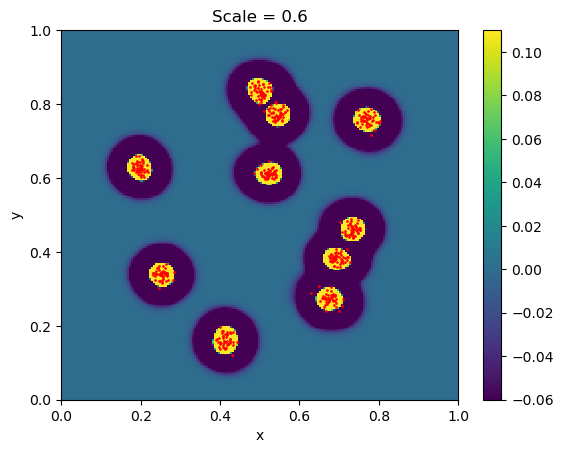

In [13]:
cwt_map = gen_cwt_map_(arr_data, mesh_bxby, arr_a, mexh)
plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='viridis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=-0.06, vmax=0.11))
plt.scatter(x_data, y_data, s = 0.8, c = 'r')
plt.colorbar(plot)
plt.title('Scale = ' + str(degree))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('y')

## Wavelet Transformation on Data Consisting of Smooth Background and Point Sources
By vectorizing the calculation, we gain speed at the cost of computer memory. For data consisting of more points, vectorization is not possible and we must loop over some of the variables. We loop over horizontal lines (the looping variable is the height of the horizontal line). This prevents us from being able to generate a meaningfully dense background to showcase how the CWT filters out the background. 

For further discussion of the CWT on point source detection in a flat region, read the notes and code in `extra/flat_ps_detection`.